# Selective lesioning
Now, our aim is to erode a model in a **controlled manner**. Michael Levin's "multiple levels of competency" (planaria; evaluate biology by how well it reacts to errors) is a main inspiration. How can higher level layers of "agents" resolve errors from lower levels? Why are these systems (biological agents + llm's) so robust? How robust is our model to perturbances? 

Model performance is tracked by benchmarking over a question set (generated w/ an assist from gpt-4 :)). 

To do: 
+ Load base model + replace mps code x
+ Pull in question set x
+ Write some code to test/track tokens per second
+ Establish basic eval framework - need to (1) feed questions (async?); (2) randomly shut off weights from non-embed layers; (3) track perf. changes as culling increases
+ think abt ways to selectively kill off weights :) (got some good suggestions from group :D)
+ (lower prio) Figure out way to track code efficiency/read up on o complexity 

Notes: 
+ Keep an eye on mem. use - disk space can be monitored via `du -hs $HOME /workspace/*` - we have 100GB avail. 

In [15]:
# Load libraries
# import flash_attn
from dotenv import main
import torch
import torch.nn as nn
import json
import jinja2
import os
import sys
import re
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig # for quantization
import plotly
from transformers import pipeline, set_seed

# auth for gated repos (like llama) - gen token here: https://huggingface.co/settings/tokens
from huggingface_hub import notebook_login
notebook_login(os.getenv('HF_TOKEN'))

# model ids
model_id = ["microsoft/Phi-3-mini-4k-instruct"]

# Set seed for reproducibility 
torch.random.manual_seed(0)

# Increase max width of pd df columns 
pd.set_option('max_colwidth', 300)

# Instantiate jinja environment - used later for icl prompting 
environment = jinja2.Environment()

device = 'cuda'

# requirements.txt
# !pip3 freeze > requirements.txt

User is already logged in.


In [2]:
# Define utility functions 
# mem. monitoring! 
def check_memory():
    print("Allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
    print("Reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
    print("Total: %fGB"%(torch.cuda.get_device_properties(0).total_memory/1024/1024/1024))

# notification/text-to-speech
def text_to_speech(text):
    if sys.platform == 'darwin':
        os.system(f'say "{text}"')
    elif sys.platform.startswith('linux'):
        os.system(f'espeak "{text}"')
    else:
        print("Text-to-speech is not supported on this platform.")

# parse + template phi inputs
def parse_phi(messages: list[dict], append_response_start = True) -> str:
    """
    Converts a multi-turn conversation into a Llama-3-tokenizable input.

    Output format:
    # <s><|system|>
    # You are a helpful AI assistant.<|end|>
    # <|user|>
    # Guess my dog's name!<|end|>
    # <|assistant|>
    """
    format = '<s>'
    
    format += '\n'.join([f"<|{m['role']}|>\n{m['content']}<|end|>" for m in messages])

    if append_response_start:
        format += "\n<|assistant|>"
    
    return format

# print(parse_phi([
#     {'role': 'system', 'content': 'Hello'}, {'role': 'user', 'content': '1+1?'}, {'role': 'assistant', 'content': '2'}
# ], False))

# model eval
def eval_model(model, tokenizer, prompt):
    tokens = tokenizer(prompt, return_tensors = 'pt').to(device)
    model.eval()
    with torch.no_grad():
        res = model.generate(
            **tokens,
            max_new_tokens = 128,
            do_sample = True,
            temperature = 0.6,
            top_p = 0.9,
            eos_token_id = [tokenizer.eos_token_id, tokenizer.convert_tokens_to_ids(tokenizer.eos_token)]
        )
    return tokenizer.batch_decode(res)[0]

In [123]:
# Load bnb config, base model, and tokenizer
bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_use_double_quant = True,
    bnb_4bit_quant_type = 'nf4',
    bnb_4bit_compute_dtype = torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_id[0],
    device_map = 'auto', # not sure what's up with device_map, but this is what causes errors
    quantization_config = bnb_config,
    trust_remote_code = True
)

# Load tokenizer - remove bos token since my function already pre-pends
tokenizer = AutoTokenizer.from_pretrained(model_id[0],
                                         add_eos_token = False,
                                         add_bos_token = False,
                                         padding_side = 'left')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Initial eval. setup
Here, we template our questions and run an initial evaluation of phi-3's performance before modification.

In [4]:
# set base prompt 
base_prompt = [
    {
        "role": "system",
        "content": "You are a helpful, honest, and intelligent AI assistant who can only respond with a single JSON object. Solve each of the following questions. Return a JSON object containing two keys, `rationale` and `answer`."
    },
    {
        "role": "user",
        "content": "What's the integer ceiling of 5/3?\nA. 3\nB. 4.25\nC. dog\nD. 2"
    },
    {
        "role": "assistant",
        "content": '{"rationale": "5/3 is between 1 (3/3) and 2 (6/3), so the integer ceiling is 2.", "answer": "D"}'
    }, 
    {
        "role": "user",
        "content": "What's the capital of the U.S. state of Georgia?\nA. Tblisi\nB. Atlanta\nC. Nashville\nD. Toronto"
    },
    {
        "role": "assistant",
        "content": '{"rationale": "The capital of the U.S. state of Georgia is Atlanta, located in the Northwest of the state.", "answer": "B"}'
    }
]

In [5]:
# create eval/questions df 
# GPT-4 generation prompt
# I am benchmarking an LLM. I want you to create 100 MMLU-style questions. Return them in a JSON array of the format specified below. The questions should be a mix of easy/medium/hard difficulty. 
# The types should be "math", "extraction", "reasoning", "facts". 
# - "Math" questions should be related to arithmetic, calculus, or statistics. 
# - "Extraction" questions should focus on NLP-style NER tasks.
# - "Reasoning" should focus on logic. 
# - "Facts" should be focused on facts related to science or nature.
# Here is an example of a question (do not use this question).
# ```
# [
# {"question": "Suppose you have a data source that generates binary messages. Each message can either be 0 or 1. If both outcomes are equally likely, what is the entropy of this data source?", "options": [{"code": "A", "text": "0 bits"}, {"code": "B", "text": "0.5 bits"}, {"code": "C", "text": "1 bit"}, {"code": "D", "text": "2 bits"}], "solution": "C", "difficulty": "hard", "type": "math"},
# {"question": "What element is represented by the symbol 'Na' on the periodic table?", "options": [{"code": "A", "text": "Nitrogen"}, {"code": "B", "text": "Nickel"}, {"code": "C", "text": "Neon"}, {"code": "D", "text": "Sodium"}], "solution": "D", "difficulty": "easy", "type": "facts"},
# ]
# ```

# Load questions.json
q_file_path = os.getcwd() + '/data/question.json'
q_file = open(q_file_path)
q_list = json.load(q_file) # yields list of dicts 


# create list of dicts, with addtl. keys allocated for full question + llm input
eval_df = pd.DataFrame(q_list).assign(
     full_question = lambda df: df.apply(lambda row: row['question'] + '\n' + '\n'.join([o['code'] + '. ' + o['text'] for o in row['options']]),  axis = 1),
     llm_input = lambda df: df.apply(lambda row: parse_phi(base_prompt + [{'role': 'assistant', 'content': row['full_question']}]), axis = 1)
)

# print(len(eval_df)) 
# print(eval_df['llm_input'][0]) # check on single input to ensure correct structure :) 
# eval_df.groupby('difficulty').count() # overall eval metrics

In [7]:
# question + answer - generate validation dictionary 
# is it better to keep eval_df as a list of dicts like prev? isn't iterrows() slightly less efficient? 
curated_eval_df = eval_df[eval_df['type'] != 'math'] # have to remove math for now, failure rates too high; prob. issue w/ trying to output latex etc.

val = []
for idx, row in curated_eval_df.iterrows(): # limit to first 10 rows for now during testing 
    print(f"Now processing question {idx}") 

    # answer validation 
    keep_going = True 
    
    while keep_going == True: 
        # generate response 
        response = eval_model(model = base_model, tokenizer = tokenizer, prompt = row['llm_input'])
        # print(response)

        # error handling for malformed outputs 
        response_json = re.findall(r'(?=.*"rationale")(?=.*"answer"){.*?}', response)[-1] # extract response + json

        # initialize keep_going + check if response_json is empty list 
        try:
            response_dict = json.loads(response_json)
            
            # validate model preds against correct answer 
            if response_dict['answer'] == row['solution']:
                # print('✅ Good answer - 😎👍')
                is_correct_pred = 1
            elif response_dict['answer'] != row['solution']: 
                # print('❌ Wrong answer!!') 
                is_correct_pred = 0
                
            # validation dictionary 
            val_dict = {'question': row['question'], 'response': response_json,
                        'difficulty': row['difficulty'],
                        'answer': response_dict['answer'],
                        'rationale': response_dict['rationale'],
                        'correct_solution': row['solution'],
                        'is_correct_pred': is_correct_pred} 
            print(val_dict['question'], '\n\n')
            val.append(val_dict)
            keep_going = False

        except Exception as e:
            print("Exception occurred:", e)

# notify when execution finishes
text_to_speech("Hello, responses are done generating!")

Now processing question 1


You are not running the flash-attention implementation, expect numerical differences.


What element is represented by the symbol 'Na' on the periodic table? 


Now processing question 3
From the text: 'The cat, which was grey, jumped over the sleepy dog.' Identify the color of the cat. 


Now processing question 4
If it is true that all roses are flowers and some flowers fade quickly, which statement must be true? 


Now processing question 5
What planet is known as the 'Red Planet'? 


Now processing question 7
Extract the occupation of the main character from the sentence: 'John, a skilled carpenter, built the house in one year.' 


Now processing question 8
If a tree falls in a forest and no one is around to hear it, does it make a sound? 


Now processing question 9
What is the boiling point of water in Celsius? 


Now processing question 11
From the statement: 'During the night, the shimmering lights of the city are visible from my apartment.', identify the time of day mentioned. 


Now processing question 12
If all cars are vehicles and some vehicles are boats, wha

sh: 1: espeak: not found


In [8]:
# prediction summary (allow this to serve as control - eventually will want to store output more formally :))
val_df = pd.DataFrame(val)

# metrics 
n_responses = len(val_df)
accuracy = sum(val_df['is_correct_pred'])/n_responses

print(f"n_responses = {n_responses}\naccuracy: {accuracy}")

n_responses = 188
accuracy: 0.675531914893617


# Performance under perturbance

There are two steps here: **(1) need to identify phi-3 activation layers** (can do this by doing a forward pass, storing output, and looking at output distribution) and **(2) determine/carry out weight culling using a given method** (e.g. randomly killing weights, sort weights by magnitude and kill the smallest first, forward passes over multiple inputs + look at average firing for neurons and cull the weights feeding into neurons with low activation across inputs). 

In [60]:
# Identify phi-3 activation layers 
layer_names = []
for idx, (name, param) in enumerate(base_model.named_parameters()): 

    # store layer names (for testing) 
    layer_names.append({'idx': idx, 'name': name})

# view layers 
# pd.DataFrame(layer_names)

# Tracking activations (w/ forward hooks) 


In [59]:
# store activations 
activation = {} 

# define function to capture activations 
def getActivation(name): 
    # hook signature 
    def hook(model, input, output): 
        activation[name] = output.detach() 
    return hook

# set a single, sample input 
test_input = eval_df['llm_input'][0]

# register forward hooks on a chosen layer - let's choose model.layers.0.self_attn.o_proj.weight for now :) 
h1 = base_model.model.layers[0].register_forward_hook(getActivation('self_attn')) # tk - question about how we know what comprises a layer? what's the right level of hierarchy to discuss at?

# forward pass + store activations for this pass - this step has an issue; 'tuple object has no attribute detach'
test_response = eval_model(model = base_model, tokenizer = tokenizer, prompt = test_input)[0]

# print activation 
print(activation)

# detach hooks 
h1.remove()              

AttributeError: 'tuple' object has no attribute 'detach'

In [ ]:
# write code to zero out like 10% of a single layer 

In [146]:
activation = {}
for name, child in base_model.model.layers[0].named_children(): 
    print(name, child)
    if name == 'mlp': 
        my_child_h1 = child.register_forward_hook(getActivation('mlp'))


# detach hooks at end to prevent memory errors 

outputs = []
with torch.no_grad(): 
    # base_model('banana')
    bn_tok = tokenizer('banana', return_tensors = 'pt').to(device)
    outputs.append(base_model(**bn_tok))

self_attn Phi3Attention(
  (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
  (qkv_proj): Linear4bit(in_features=3072, out_features=9216, bias=False)
  (rotary_emb): Phi3RotaryEmbedding()
)
mlp Phi3MLP(
  (gate_up_proj): Linear4bit(in_features=3072, out_features=16384, bias=False)
  (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
  (activation_fn): SiLU()
)
input_layernorm Phi3RMSNorm()
resid_attn_dropout Dropout(p=0.0, inplace=False)
resid_mlp_dropout Dropout(p=0.0, inplace=False)
post_attention_layernorm Phi3RMSNorm()


In [163]:
import torch
import numpy as np
import matplotlib.pyplot as plt 
mlp_output = activation['mlp'].squeeze().cpu().numpy().flatten() # squeeze to remove batch dim.; flatten - necessary for plotting 



In [171]:
mlp_output*100

array([ 5.2   , -1.294 , -5.566 , ...,  1.135 ,  1.343 ,  0.2869],
      dtype=float16)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        7.810e+02, 5.348e+03, 6.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([-214.        , -197.75      , -181.5       , -165.25      ,
        -149.        , -132.75      , -116.5       , -100.25      ,
         -84.        ,  -67.75      ,  -51.53125   ,  -35.28125   ,
         -19.03125   ,   -2.79101562,   13.453125  ,   29.703125  ,
          45.9375    ,   62.1875    ,   78.4375    ,   94.6875    ,
         110.9375    ]),
 <BarContainer object of 20 artists>)

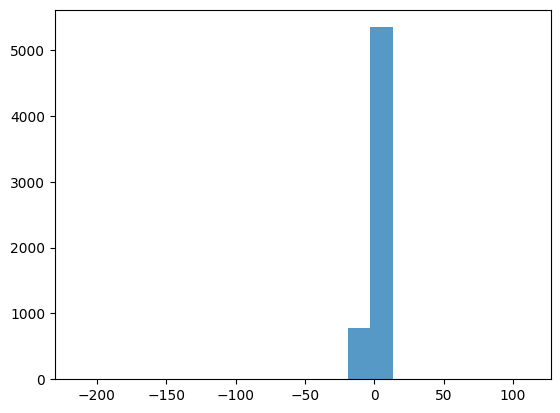

In [172]:
plt.hist(mlp_output*100, bins = 20, alpha = 0.75)

In [117]:
# to get activations for internal layers do below
for name, child in my_child.named_children(): 
    print(name, child)
    if name == 'o_proj': 
        my_grandie_h1 = child.register_forward_hook(getActivation('o_proj'))



o_proj Linear4bit(in_features=3072, out_features=3072, bias=False)
qkv_proj Linear4bit(in_features=3072, out_features=9216, bias=False)
rotary_emb Phi3RotaryEmbedding()


Linear4bit(in_features=3072, out_features=3072, bias=False)

In [118]:
my_grandie_h1

In [99]:
# for module in base_model.model.layers[0].modules(): 
#     print(module)

layer = base_model.model.named_parameters()
for name, module in layer.named_children():
    print(name, module)


AttributeError: 'generator' object has no attribute 'named_children'

In [49]:
layer_names = []
for idx, (name, param) in enumerate(base_model.named_parameters()): 
    print(idx, name, param)

0 model.embed_tokens.weight Parameter containing:
tensor([[-5.8594e-02, -4.0894e-03,  1.5564e-03,  ..., -2.3438e-02,
          3.8818e-02, -5.9082e-02],
        [-3.0273e-02,  9.1309e-02,  5.6152e-02,  ...,  1.0132e-02,
         -2.1606e-02, -2.4170e-02],
        [-3.3264e-03,  3.1982e-02,  9.0942e-03,  ...,  9.4414e-05,
         -6.9275e-03, -2.7832e-02],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], device='cuda:0', dtype=torch.float16,
       requires_grad=True)
1 model.layers.0.self_attn.o_proj.weight Parameter containing:
Parameter(Params4bit([[148],
            [158],
            [191],
            ...,
            [ 99],
            [ 62],
            [212]], device='cuda:0', dtype=torch.uint8))
2 model.lay

In [100]:
base_model.model.named_parameters()

<generator object Module.named_parameters at 0x7f3205ce4eb0>

In [9]:
# Killing weights randomly across layers 
# Here, we simply kill a random portion of weights across layers, scaling up from 10-90% of weights in 5% increments. The only goal here is 
# to see how performance changes. 

# Desired output: line chart tracking successively increasing performance decay. 

# 1. Subset out activation layers (these are the ones we can modify) and count # of neurons across them so we can figure out which quantity = 10, 15, 20% etc. :) 
## a. Look at layer outputs; run forward pass and store intermediary computations - this tells us which are the activation layers 

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear4bit(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3RotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear4bit(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_features=3072, o

In [71]:
# layer_names # these are the available layers 
torch.nn.ModuleList([layer for i, layer in enumerate(base_model.model.layers) if i != 16])

ModuleList(
  (0-30): 31 x Phi3DecoderLayer(
    (self_attn): Phi3Attention(
      (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
      (qkv_proj): Linear4bit(in_features=3072, out_features=9216, bias=False)
      (rotary_emb): Phi3RotaryEmbedding()
    )
    (mlp): Phi3MLP(
      (gate_up_proj): Linear4bit(in_features=3072, out_features=16384, bias=False)
      (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
      (activation_fn): SiLU()
    )
    (input_layernorm): Phi3RMSNorm()
    (resid_attn_dropout): Dropout(p=0.0, inplace=False)
    (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
    (post_attention_layernorm): Phi3RMSNorm()
  )
)